In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import sympy

sympy.init_printing()

style_name = 'bmh' #bmh
mpl.style.use(style_name)
np.set_printoptions(precision=4, linewidth =150)

style = plt.style.library[style_name]
style_colors = [ c['color'] for c in style['axes.prop_cycle'] ]

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from IPython.core.display import display, HTML

init_notebook_mode(connected=True)

# https://github.com/plotly/plotly.py/issues/515
# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))


### 최적화 워밍 업

- 캔 설계 문제인 다음 최적화 문제를 생각해보자.

- 그래프와 최적해를 함께 보면서 목적함수의 의미는 무엇인지 제약조건의 의미는 무엇인지 생각해보자.

$$
\begin{aligned}
\text{minimize} \qquad & \pi D H + \frac{\pi}{2} D^2 \\[10pt]
\text{s.t.} \qquad & 3 \leq D \leq 8 \\[10pt]
& 8.5 \leq H \leq 17.5 \\[10pt]
& \frac{\pi}{4} D^2 H \geq 600
\end{aligned}
$$

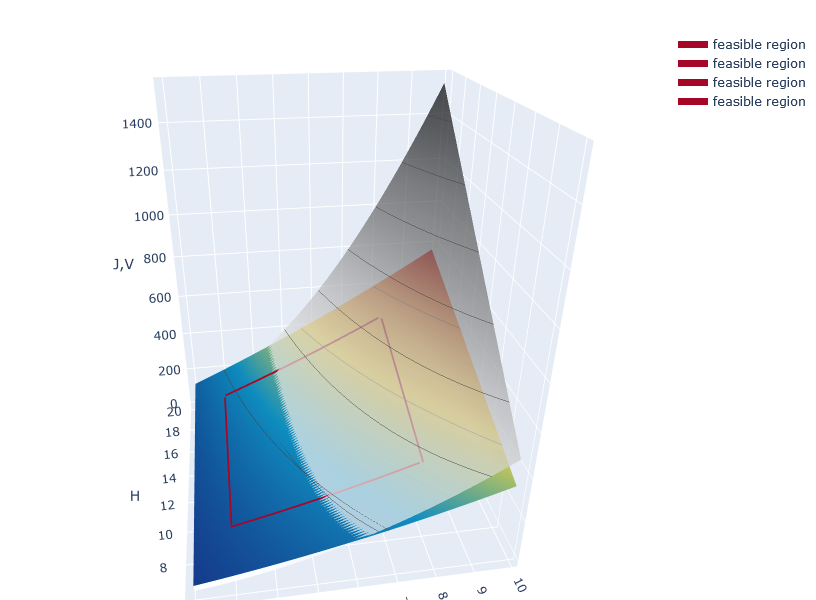

In [2]:
D_lbound = 3
D_rbound = 8
H_lbound = 8.5
H_rbound = 17.5

def J(x) :
    """
    캔의 표면적 함수
    x[0]:D
    x[1]:H
    """
    D = x[0]
    H = x[1]
    return  (np.pi*D**2)/2 + np.pi*D*H 

def V(x) :
    """
    캔의 부피 함수
    x[0]:D
    x[1]:H
    """
    D = x[0]
    H = x[1]
    return np.pi/4 * D**2 * H

d = np.arange(2, 10, 0.1)
d_fsb = np.arange(D_lbound, D_rbound, 0.1)
h = np.arange(6, 20, 0.1)
h_fsb = np.arange(H_lbound, H_rbound, 0.1)
D, H = np.meshgrid(d, h)
Js = J(np.array([D, H]))

top    = J(np.array( [d_fsb, np.ones(d_fsb.shape)*H_rbound] ))
bottom = J(np.array( [d_fsb, np.ones(d_fsb.shape)*H_lbound ] ))
left   = J(np.array( [np.ones(h_fsb.shape)*D_lbound, h_fsb]))
right  = J(np.array( [np.ones(h_fsb.shape)*D_rbound, h_fsb]))

Vs = V(np.array([D, H]))

# 주어진 곡면
surf_Js = go.Surface(x=D, y=H, z=Js, showscale=False, colorscale='Portland', name='surface area',
                  contours=dict(
                      x=dict(show=False, highlight=False),
                      y=dict(show=False, highlight=False),
                      z=dict(show=True,  highlight=True, highlightcolor='#A60628'),
                  ), opacity=1.,
                 )


feasible_top = go.Scatter3d(x=d_fsb, y=np.ones(d_fsb.shape)*H_rbound, z=top,
                            mode='lines', name='feasible region',
                            line = dict(color = '#A60628', width = 7,))

feasible_btm = go.Scatter3d(x=d_fsb, y=np.ones(d_fsb.shape)*H_lbound, z=bottom,
                            mode='lines', name='feasible region',
                            line = dict(color = '#A60628', width = 7,))

feasible_lft = go.Scatter3d(x=np.ones(h_fsb.shape)*D_lbound, y=h_fsb, z=left,
                            mode='lines', name='feasible region',
                            line = dict(color = '#A60628', width = 7,))

feasible_rht = go.Scatter3d(x=np.ones(h_fsb.shape)*D_rbound, y=h_fsb, z=right,
                            mode='lines', name='feasible region',
                            line = dict(color = '#A60628', width = 7,))

surf_Vs = go.Surface(x=D, y=H, z=Vs, showscale=False, colorscale='Greys', name='volume',
                  contours=dict(
                      x=dict(show=False, highlight=False),
                      y=dict(show=False, highlight=False),
                      z=dict(show=True,  highlight=True, highlightcolor='#A60628'),
                  ), opacity=0.7,
                 )

data = [surf_Js, surf_Vs,feasible_top,feasible_btm,feasible_lft,feasible_rht]

layout = go.Layout(
    autosize=False, 
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=30),
    scene=dict(aspectratio=dict(x=1, y=1, z=1.3),
               xaxis=dict(title="D", showspikes=False),
               yaxis=dict(title="H", showspikes=False),
               zaxis=dict(title="J,V", showspikes=True, spikecolor='#0072b2', spikesides=False),
              ),
   
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [3]:
from scipy.optimize import Bounds, NonlinearConstraint
from scipy.optimize import minimize

In [4]:
def f(x):
    D = x[0]
    H = x[1]
    return  (np.pi*D**2)/2 + np.pi*D*H 

def df(x):
    D = x[0]
    H = x[1]
    return (np.pi*(D+H), np.pi*D)

def constraint(x):
    D = x[0]
    H = x[1]
    return ((np.pi/4) * D**2 * H) - 600

# 바운드 제약조건과 비선형 제약조건
bounds = Bounds([D_lbound, H_lbound], [D_rbound, H_rbound])
cons   = ({'type': 'ineq', 'fun': constraint})

res = minimize(f, [7.0, 15.0], jac=df, method='slsqp', bounds=bounds, constraints=cons)

print(res)

     fun: 400.5309653569468
     jac: array([62.6327, 25.1327])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 8.    , 11.9366])


In [5]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """
   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style("../../style.css")